In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from typing import List, Dict


In [20]:
# VGG-16 Layer Names and Channels
vgg16_layers = {
    "conv1_1": 64,
    "relu1_1": 64,
    "conv1_2": 64,
    "relu1_2": 64,
    "pool1": 64,
    "conv2_1": 128,
    "relu2_1": 128,
    "conv2_2": 128,
    "relu2_2": 128,
    "pool2": 128,
    "conv3_1": 256,
    "relu3_1": 256,
    "conv3_2": 256,
    "relu3_2": 256,
    "conv3_3": 256,
    "relu3_3": 256,
    "pool3": 256,
    "conv4_1": 512,
    "relu4_1": 512,
    "conv4_2": 512,
    "relu4_2": 512,
    "conv4_3": 512,
    "relu4_3": 512,
    "pool4": 512,
    "conv5_1": 512,
    "relu5_1": 512,
    "conv5_2": 512,
    "relu5_2": 512,
    "conv5_3": 512,
    "relu5_3": 512,
    "pool5": 512,
}

In [31]:
class AdapLayers(nn.Module):
    """Small adaptation layers."""
    def __init__(self, hypercolumn_layers: List[str], output_dim: int = 128):
        super(AdapLayers, self).__init__()
        self.layers = []
        channel_sizes = [vgg16_layers[name] for name in hypercolumn_layers]
        for i, l in enumerate(channel_sizes):
            layer = nn.Sequential(
                nn.Conv2d(l, 64, kernel_size=1, stride=1, padding=0),
                nn.ReLU(),
                nn.Conv2d(64, output_dim, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(output_dim),
            )
            self.layers.append(layer)
            self.add_module("adap_layer_{}".format(i), layer)

    def forward(self, features: List[torch.tensor]):
        for i, _ in enumerate(features):
            features[i] = getattr(self, "adap_layer_{}".format(i))(features[i])
        return features

class S2DNet(nn.Module):
    def __init__(self, device: torch.device, hypercolumn_layers: List[str], checkpoint_path: str = None):
        super(S2DNet, self).__init__()
        self._device = device
        self._hypercolumn_layers = hypercolumn_layers
        vgg16 = models.vgg16(pretrained=False)
        self.encoder = nn.Sequential(*list(vgg16.features.children())[:-2]).to(device)
        self.adaptation_layers = AdapLayers(hypercolumn_layers).to(device)
        self.layer_indices = {name: idx for idx, name in enumerate(vgg16_layers) if name in hypercolumn_layers}
        
        if checkpoint_path:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            self.load_state_dict(checkpoint['state_dict'])

    def forward(self, image_tensor: torch.FloatTensor):
        feature_maps = []
        x = image_tensor.to(self._device)
        for idx, layer in enumerate(self.encoder):
            x = layer(x)
            layer_name = list(vgg16_layers.keys())[idx]
            if layer_name in self._hypercolumn_layers:
                feature_maps.append(x)
        adapted_features = self.adaptation_layers(feature_maps)
        return adapted_features

In [32]:
# Assuming you have a function to load and preprocess your image
def load_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

In [33]:

# Load model and image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = S2DNet(device, ["conv1_2", "conv3_3", "conv5_3"], 's2dnet_weights.pth')
model.eval()

image_path = 'buddha2.jpeg'
image = load_image(image_path, device)
features = model(image)
print(features)

[tensor([[[[ 2.2946e-01,  3.2376e-01,  2.8921e-01,  ...,  1.2417e-01,
           -1.2340e-01,  3.9977e-02],
          [ 4.7003e-02, -8.6544e-02,  5.4502e-02,  ..., -2.6030e-01,
           -4.0128e-01, -1.4229e-01],
          [ 3.3564e-01,  2.9416e-01,  5.3289e-01,  ...,  7.2822e-02,
            8.2392e-02, -3.1896e-02],
          ...,
          [ 3.8266e-01,  5.1471e-01,  6.5648e-01,  ...,  9.6953e-02,
           -2.6235e-01, -4.4693e-01],
          [ 2.3278e-01,  3.6918e-01,  6.3378e-01,  ...,  9.6949e-02,
           -9.6948e-02, -2.8536e-01],
          [ 8.4576e-02,  1.9718e-02,  2.6498e-01,  ..., -1.3238e-01,
           -1.3222e-01, -2.8329e-01]],

         [[-8.5064e-02, -6.6949e-02, -3.0699e-01,  ..., -5.5767e-01,
           -2.6582e-01, -5.3402e-02],
          [-7.3367e-02, -7.6611e-02, -2.4182e-01,  ..., -8.1416e-02,
            3.3254e-05, -1.3301e-01],
          [-9.4222e-02, -2.2879e-01, -2.0355e-01,  ..., -1.9825e-01,
           -9.9257e-02, -3.2712e-01],
          ...,
    

Shape of features_tensor: torch.Size([3, 1, 128, 64, 64])
Shape of the selected image slice: (64, 64)


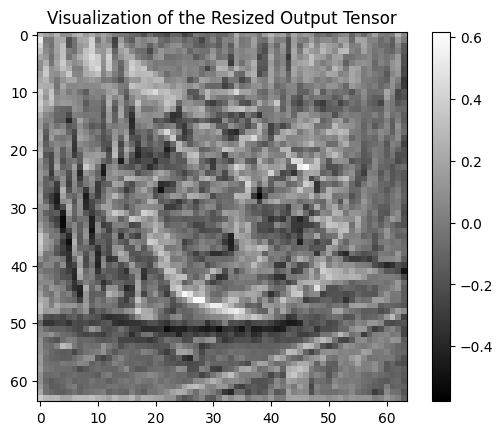

In [42]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Define a common size, for example, the smallest dimensions in your list
common_size = (64, 64)  # Adjust as necessary

# Resize tensors
resized_tensors = [TF.resize(t, common_size) if t.size()[2:] != common_size else t for t in features]

# Stack the resized tensors
features_tensor = torch.stack(resized_tensors)

# Move the tensor to CPU, detach it from the graph, and convert to numpy
output_numpy = features_tensor.cpu().detach().numpy()

# Print shapes to debug
print("Shape of features_tensor:", features_tensor.shape)
print("Shape of the selected image slice:", output_numpy[0, 0, 0, :, :].shape)

# Select the first tensor, first channel, first feature map for visualization
image = output_numpy[0, 0, 0, :, :]  # Ensure this index points to a single (64, 64) feature map

plt.imshow(image, cmap='gray')  # Ensure image is a 2D array
plt.colorbar()
plt.title('Visualization of the Resized Output Tensor')
plt.show()

In [19]:
print(model)


S2DNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation